# Sources of water

We consider pore water and chemically bound water within major volatile-carrying reservoirs. Table 3 in Faccenda (2014) is a useful resource summarising each component. We produce grids of the in-plate water content in Mt/m$^2$ for each reservoir.

#### Key references

1. Faccenda, M. Water in the slab: A trilogy. Tectonophysics 614, 1–30 (2014). doi:[10.1016/j.tecto.2013.12.020](http://dx.doi.org/10.1016/j.tecto.2013.12.020)
2. Jarrard, R. D. Subduction fluxes of water, carbon dioxide, chlorine, and potassium. Geochemistry, Geophys. Geosystems 4, (2003). doi:[10.1029/2002GC000392](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002GC000392)
3. Van Keken, P. E., Hacker, B. R., Syracuse, E. M. & Abers, G. A. Subduction factory: 4. Depth-dependent flux of H2O from subducting slabs worldwide. J. Geophys. Res. Solid Earth 116, (2011). doi:[10.1029/2010JB007922](http://dx.doi.org/10.1029/2010JB007922)
4. Hacker, B. R. H2O subduction beyond arcs. Geochemistry, Geophys. Geosystems 9, (2008). doi:[10.1029/2007GC001707](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007GC001707)

#### Contents

1. [water in the lithosphere](#water-in-the-lithosphere)
2. [water in sediments](#water-in-sediments)
3. [water in the crust](#water-in-the-crust)

__Create directory structure__

First, we must make sure the directories exist for us to put the grids corresponding to each carbon reservoir

In [1]:
import os
folder_name = "Muller22_Sep17"
parent_dir = "./H2O_Review_Bundle/{}/".format(folder_name)

# Lithosphere
lithosphere_top_dir = parent_dir+"Reservoirs/Lithosphere/top/"
lithosphere_bottom_dir = parent_dir+ "Reservoirs/Lithosphere/bottom/"

# Crust
crust_bound_dir = parent_dir+"Reservoirs/Crust/bound/"
crust_pore_dir  = parent_dir+"Reservoirs/Crust/pore/"

# Sediments
sediments_bound_dir = parent_dir+"Reservoirs/Sediment/bound/"
sediments_pore_dir = parent_dir+"Reservoirs/Sediment/pore/"

# create directories if they do not already exist
for path in [lithosphere_top_dir,
             lithosphere_bottom_dir,
             crust_bound_dir,
             crust_pore_dir,
             sediments_bound_dir,
             sediments_pore_dir]:
    
    for m in ["min", "mean", "max"]:
        full_path = path + m + "/"
        if not os.path.exists(full_path):
            os.makedirs(full_path)
        
figure_dir = parent_dir+"figures"
os.makedirs(figure_dir, exist_ok=True)

In [2]:
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage
from IPython.display import clear_output
import glob, os
from joblib import Parallel, delayed
%matplotlib inline
# plt.style.use('ggplot')

# common data files
grid_directory = "../Muller2022_InputGrids/"
spreadrate_filename = grid_directory+"SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.2f}Ma.nc"
agegrid_filename = grid_directory+"SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.009e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# netCDF4 grid resolution
spacingX = 0.2
spacingY = 0.2
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

save_output_netcdf = True # !! important

In [3]:
import gplately
from gplately import tools
from gplately import pygplates
from gplately.grids import read_netcdf_grid, write_netcdf_grid

gdownload = gplately.download.DataServer("Muller2022", verbose=False)
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use GPlately's DataServer to get coastlines and continents
coastlines, continents, COBs = gdownload.get_topology_geometries()

model = gplately.PlateReconstruction([f for f in rotation_model.filenames if "1000_0_rotfile_Merdith_et_al_optimised.rot" in f][0], topology_features, static_polygons)
gplot = gplately.PlotTopologies(model, coastlines, continents)

In [31]:
print(model.rotation_model.filenames[-1])

/Users/lila0720/Library/Caches/gplately/Muller2022.unzip/Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2.2/optimisation/1000_0_rotfile_MantleOptimised.rot


In [5]:
cell_area = tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

## water in the lithosphere

H$_2$O influx and outflux is related to the following parameters:

- $u$ Spreading rate
- $d$ Compaction length (fixed?)
- $T$ Temperature of the mantle
- $c$ Fertility of the mantle
- $v$ H2O volatile content (elevated near hotspots)

These are fitted from a series of polynomial functions to get units of t/m/yr.

__Ridge outflux fit:__

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}})
$$

__Plate influx fit:__

This is actually metasomatism connected to the base of the lithosphere and is separate from serpentinisation due to mantle unroofing which occurs at the surface.

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}}) + C_v (v^2 - v_{\mathrm{ref}}^2)
$$

We want to convert t/m/yr to t/m2

> __Citation:__
> Keller, T., Katz, R. F., & Hirschmann, M. M. (2017). Volatiles beneath mid-ocean ridges: Deep melting, channelised transport, focusing, and metasomatism. Earth and Planetary Science Letters, 464, 55–68. https://doi.org/10.1016/j.epsl.2017.02.006

In [6]:
u_ref = 3.0
d_ref = 1.504
T_ref = 1350.0
c_ref = 19.0
v_ref = 100.0 
delta_v_ref = 20.0

def ridge_outflux(u, d, T, c, v):
    u = np.abs(u)
    A = 0.9919
    B_u = 0.3162
    B_d = -0.3739
    B_T = 0.0089
    B_c = 0.0294
    B_v = 0.0095
    return A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref)

def plate_influx(u, d, T, c, v):
    u = np.abs(u)
    A = 0.8807
    B_u = 0.262
    B_d = 0.3589
    B_T = -0.00029097
    B_c = 0.0075
    B_v = 0.0054
    C_v = 0.000035532
    F = A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref) + \
         C_v*(v**2 - v_ref**2)
    return F

print(ridge_outflux(u_ref, d_ref, T_ref, c_ref, 150.0))
print(plate_influx(u_ref, d_ref, T_ref, c_ref, 150.0))

1.4668999999999999
1.59485


In [7]:
subduction_data = model.tessellate_subduction_zones(0, tessellation_threshold_radians, ignore_warnings=True)
subduction_lon = subduction_data[:,0]
subduction_lat = subduction_data[:,1]
subduction_length  = np.radians(subduction_data[:,6]) * pygplates.Earth.mean_radius_in_kms * 1e3 # in metres
subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
subduction_convergence = np.clip(subduction_convergence, 0, 1e99)

ridge_data = model.tessellate_mid_ocean_ridges(0, tessellation_threshold_radians, ignore_warnings=True)
ridge_lon = ridge_data[:,0]
ridge_lat = ridge_data[:,1]
ridge_vel = ridge_data[:,2]
ridge_length = np.radians(ridge_data[:,3]) * 1e3 * pygplates.Earth.mean_radius_in_kms

v_min = v_ref - delta_v_ref
v_mean = v_ref
v_max = v_ref + delta_v_ref

volatile_output = ridge_outflux(0.5*ridge_vel, d_ref, T_ref, c_ref, v_mean)

print("Average volatile extraction rate = {:.2f} t/m/yr".format(volatile_output.mean()))
print("Global volatile output = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output * ridge_length).sum()*1e-6,
    (volatile_output * ridge_length).sum()*1e3/1e12))

Average volatile extraction rate = 0.84 t/m/yr
Global volatile output = 48.31 Mt/yr = 0.05 x10^12 kg/yr


__Plate influx at top of mantle lithosphere__

The __Iyer et al. 2010__ model of mantle hydration related to half-spreading rate. We fit their curves using the function,

$$
f(x) = \frac{a}{x+b}
$$

> Iyer, K., Rüpke, L. H. & Morgan, J. P. Feedbacks between mantle hydration and hydrothermal convection at ocean spreading centers. Earth Planet. Sci. Lett. 296, 34–44 (2010). doi:[10.1016/j.epsl.2010.04.037](http://dx.doi.org/10.1016/j.epsl.2010.04.037)

In [8]:
hsr = np.array([0, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7])
h2o_lo_perm = np.array([3, 2.5, 1.8, 1.4, 1, 0.75, 0.5, 0.5, 0.5, 0.5]) * 1e5
h2o_hi_perm = np.array([3, 2.5, 1.7, 1.1, 0.6, 0.45, 0.5, 0.4, 0.3, 0.25]) *1e5

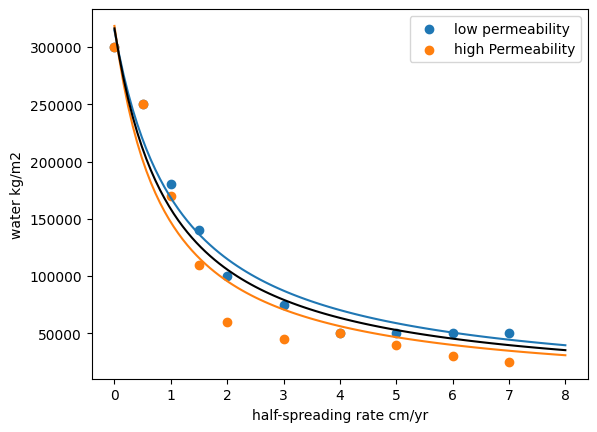

In [9]:
from scipy.optimize import curve_fit

def curve(x, a, b):
    return a/(x+b) 

popt1, pcov1 = curve_fit(curve, hsr, h2o_lo_perm)
popt2, pcov2 = curve_fit(curve, hsr, h2o_hi_perm)
popt3 = 0.5*(popt1 + popt2) # average curve

hsr_array = np.linspace(0., 8, 100)


fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='water kg/m2', xlabel='half-spreading rate cm/yr')
ax1.scatter(hsr, h2o_lo_perm, label='low permeability')
ax1.scatter(hsr, h2o_hi_perm, label='high Permeability')
# plt.plot(hsr, poly(hsr))
ax1.plot(hsr_array, curve(hsr_array, *popt1))
ax1.plot(hsr_array, curve(hsr_array, *popt2))
ax1.plot(hsr_array, curve(hsr_array, *popt3), c='k')
ax1.legend()

In [10]:
popt3

array([3.17631978e+05, 1.00414921e+00])

In [11]:
spreadrate_grid = read_netcdf_grid(spreadrate_filename.format(0), resample=(spacingX,spacingY))

# Iyer (top of lithospheric mantle)
volatile_grid = gplately.Raster(data=curve(0.5*spreadrate_grid/10, *popt3), extent=extent_globe)
volatile_grid.fill_NaNs(inplace=True)
volatile_output = volatile_grid.interpolate(subduction_lon, subduction_lat)


print("Average volatile uptake = {:.2f} kg/m2".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_length*subduction_convergence).sum()*1e-9,
    (volatile_output*subduction_length*subduction_convergence).sum()/1e12))

Average volatile uptake = 85244.31 kg/m2
Global volatile uptake = 204.91 Mt/yr = 0.20 x10^12 kg/yr


/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/gplately/grids.py:706: RuntimeWarning: Invalid values encountered in lat; clipping to [-90, 90]
  warnings.warn(


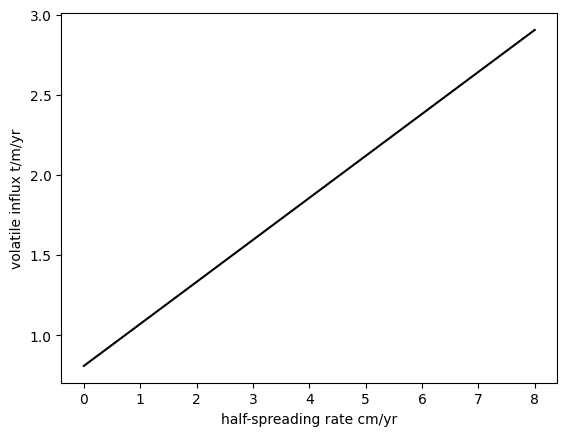

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlabel='half-spreading rate cm/yr', ylabel='volatile influx t/m/yr')
plt.plot(hsr_array, plate_influx(hsr_array, d_ref, T_ref, c_ref, 150.0), 'k-')

In [13]:
spreadrate_grid = read_netcdf_grid(spreadrate_filename.format(0), resample=(spacingX,spacingY))

# Keller (base of lithospheric mantle)
volatile_grid = gplately.Raster(data=plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, v_mean),
                                extent=extent_globe)
volatile_grid.fill_NaNs(inplace=True)
volatile_output = volatile_grid.interpolate(subduction_lon, subduction_lat)


print("Average volatile extraction rate = {:.2f} t/m/yr".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_length).sum()*1e-6,
    (volatile_output*subduction_length).sum()*1e3/1e12))

Average volatile extraction rate = 1.14 t/m/yr
Global volatile uptake = 70.26 Mt/yr = 0.07 x10^12 kg/yr


In [14]:
water_lithosphere_top_filename = lithosphere_top_dir + "{}/water_lithosphere_grid_{}.nc"
water_lithosphere_bottom_filename = lithosphere_bottom_dir + "{}/water_lithosphere_grid_{}.nc"

# for t, reconstruction_time in enumerate(reconstruction_times):

def reconstruct_water_lithosphere(reconstruction_time):
    ## Keller
    # mm/yr
    spreadrate_grid = read_netcdf_grid(spreadrate_filename.format(reconstruction_time),
                                       resample=(spacingX,spacingY))
    
    # t/m/yr
    v_min = v_ref - delta_v_ref
    v_mean = v_ref
    v_max = v_ref + delta_v_ref

    H2O_influx_grid_min  = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref,v_min)
    H2O_influx_grid_mean = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, v_mean)
    H2O_influx_grid_max  = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, v_max)
    
    water_lithosphere_bottom = np.ma.array([H2O_influx_grid_min, H2O_influx_grid_mean, H2O_influx_grid_max])
    
    # unit conversions
    water_lithosphere_bottom /= spreadrate_grid*1e-3 # mm/yr to m/yr
    water_lithosphere_bottom *= 1e-6 # convert t/m^2 to Mt/m^2
    
    ## Iyer
    H2O_influx_top_mean =  curve(0.5*spreadrate_grid/10, *popt3) * 1e-9 # convert kg/m^2 to Mt/m^2
    H2O_influx_top_min  =  curve(0.5*spreadrate_grid/10, *popt2) * 1e-9 # convert kg/m^2 to Mt/m^2
    H2O_influx_top_max  =  curve(0.5*spreadrate_grid/10, *popt1) * 1e-9 # convert kg/m^2 to Mt/m^2
    
    water_lithosphere_top = np.ma.array([H2O_influx_top_min, H2O_influx_top_mean, H2O_influx_top_max])
    
    # Mt C
    total_water_lithosphere_bottom = np.nansum(water_lithosphere_bottom*cell_area, axis=(1,2))
    total_water_lithosphere_top    = np.nansum(water_lithosphere_top*cell_area, axis=(1,2))
    
    # Clip all minimum values that are below zero to 0
    total_water_lithosphere_bottom = np.clip(total_water_lithosphere_bottom, 0., None)
    total_water_lithosphere_top = np.clip(total_water_lithosphere_top, 0., None)
    
    if save_output_netcdf:
        for i, m in enumerate(['min', 'mean', 'max']):
            write_netcdf_grid(water_lithosphere_bottom_filename.format(m, reconstruction_time),
                              water_lithosphere_bottom[i])
            write_netcdf_grid(water_lithosphere_top_filename.format(m, reconstruction_time),
                              water_lithosphere_top[i])

    return np.array(np.hstack([total_water_lithosphere_bottom, total_water_lithosphere_top]))


In [15]:
%env PYTHONWARNINGS=ignore::RuntimeWarning
        
total_water_lithosphere = Parallel(n_jobs=-2, verbose=1)(
    delayed(reconstruct_water_lithosphere)(time) for time in reconstruction_times)

total_water_lithosphere = np.array(total_water_lithosphere)
total_water_lithosphere_bottom = total_water_lithosphere[:,:3]
total_water_lithosphere_top    = total_water_lithosphere[:,3:]

env: PYTHONWARNINGS=ignore::RuntimeWarning


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  2.1min
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  9.6min finished


## water in sediments

Two sources of water in sediments: pore and bound water

1. __Pore water:__ use the sedimentary thickness grids convert to water depth based a porosity-depth relationship
2. __Bound water:__ water bound in the sediment matrix itself

In [16]:
def convert_sediment_to_water(sediment_thickness, sediment_surface_porosity=0.66, decay_constant=1333):
    """Convert sediment thickness into water thickness based on porosity assuming a single
    “average ocean floor sediment” lithology.

    
    Assuming the porosity decays exponentially, the volume of water within sediment of thickness 'T' is:
    
       Integral(porosity(z), z = 0 -> 0 + T) = Integral(porosity(0) * exp(-z / decay), z = 0 -> 0 + T)
                                             = -decay * porosity(0) * (exp(-T/decay) - 1)
                                             = decay * porosity(0) * (1 - exp(-T/decay))


    Returns a list of tuples (longitude, latitude, water_thickness)
    """
    water_thickness = decay_constant*sediment_surface_porosity * (
        1.0 - np.exp(-sediment_thickness/decay_constant))

    return water_thickness

In [17]:
sediments_filename = grid_directory+"TotalSediment/sed_thick_0.1d_{:.1f}.nc"

seds_grid = gplately.Raster(filename=sediments_filename.format(0), resample=(spacingX,spacingY))
seds_grid.fill_NaNs(inplace=True)
sediment_thickness = seds_grid.interpolate(subduction_lon, subduction_lat)

water_thickness = convert_sediment_to_water(sediment_thickness)
volatile_output = water_thickness*1020 # m to kg/m2 multiply by the density of fluid

print("-- PORE WATER --")
print("Average volatile uptake = {:.2f} kg/m2".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_convergence*subduction_length).sum()*1e-9,
    (volatile_output*subduction_convergence*subduction_length).sum()*1e-12))


matrix_thickness = sediment_thickness - water_thickness
volatile_output = 0.07*sediment_thickness*1700 # convert m to kg/m2 (multiply by mean sediment density), 7 wt%

print("-- BOUND WATER --")
print("Average volatile uptake = {:.2f} kg/m2".format(volatile_output.mean()))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    (volatile_output*subduction_convergence*subduction_length).sum()*1e-9,
    (volatile_output*subduction_convergence*subduction_length).sum()*1e-12))

-- PORE WATER --
Average volatile uptake = 155374.83 kg/m2
Global volatile uptake = 388.27 Mt/yr = 0.39 x10^12 kg/yr
-- BOUND WATER --
Average volatile uptake = 37714.55 kg/m2
Global volatile uptake = 93.86 Mt/yr = 0.09 x10^12 kg/yr


In [18]:
water_sediments_bound_filename = sediments_bound_dir+"{}/water_sediment_grid_{}.nc"
water_sediments_pore_filename  = sediments_pore_dir +"{}/water_sediment_grid_{}.nc"

def reconstruct_water_sediment(reconstruction_time):
    
    """
    # for times <= 540 Ma.
    if reconstruction_time <= 540:
        # compacted sediment thickness (metres)
        
        sedtime = reconstruction_time
    else:
        sedtime = 540
    """
    sedtime = reconstruction_time
    seds_grid = read_netcdf_grid(sediments_filename.format(sedtime), resample=(spacingX, spacingY))
 
    ## Bound H2O
    # average 7 wt% water with average density of 1700 kg/m3
    water_sediments_bound = np.ma.array([0.06*seds_grid, 0.07*seds_grid, 0.08*seds_grid])*1700
    water_sediments_bound *= 1e-9 # convert kg/m2 to Mt/m2
    
    ## Pore H2O
    water_thickness_mean = convert_sediment_to_water(seds_grid, sediment_surface_porosity=0.66)
    water_thickness_min  = convert_sediment_to_water(seds_grid, sediment_surface_porosity=0.5)
    water_thickness_max  = convert_sediment_to_water(seds_grid, sediment_surface_porosity=0.75)
    water_sediments_pore = np.ma.array([water_thickness_min, water_thickness_mean, water_thickness_max]) * 1020
    water_sediments_pore *= 1e-9 # convert kg/m2 to Mt/m2
    
    
    total_water_sediments_bound = np.nansum(water_sediments_bound*cell_area, axis=(1,2))
    total_water_sediments_pore  = np.nansum(water_sediments_pore*cell_area, axis=(1,2))

    if save_output_netcdf:
        for i, m in enumerate(['min', 'mean', 'max']):
            write_netcdf_grid(water_sediments_bound_filename.format(m, reconstruction_time),
                              water_sediments_bound[i])
            
            write_netcdf_grid(water_sediments_pore_filename.format(m, reconstruction_time),
                              water_sediments_pore[i])
    
    return np.array(np.hstack([total_water_sediments_bound, total_water_sediments_pore]))

In [19]:
%env PYTHONWARNINGS=ignore::RuntimeWarning
        
total_water_sediment = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_water_sediment)(time) for time in reconstruction_times)

total_water_sediment = np.array(total_water_sediment)
total_water_sediment_bound = total_water_sediment[:,:3]
total_water_sediment_pore  = total_water_sediment[:,3:]

env: PYTHONWARNINGS=ignore::RuntimeWarning


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-3)]: Done 1001 out of 1001 | elapsed: 12.2min finished


## water in the crust

> Jarrard, R. D. Subduction fluxes of water, carbon dioxide, chlorine, and potassium. Geochemistry, Geophys. Geosystems 4, (2003). doi:[10.1029/2002GC000392](doi.org/10.1029/2002GC000392)

In [20]:
def macro_porosity(age):
    return 13.01 - 5.625*np.log10(age)

def structural_H2O(rho, phi):
    return (103.1 - 34.27*rho) + 0.17*(1.031 - phi)

def bulk_density(phi, rho):
    return (0.01*phi)*1.02 + (1.0 - 0.01*phi)*rho

def total_crust_H2O_wt_structural(age):
    ones = np.ones_like(age)
    phi_u = macro_porosity(age)
    phi_l = phi_u/2
    rho_u = 3.01 - 0.0631*np.log10(age)
    rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    rho_d = 2.98
    rho_g = 2.99
    H2O_wt_u = structural_H2O(rho_u, phi_u)
    H2O_wt_l = structural_H2O(rho_l, phi_l)
    H2O_wt_d = 1.76
    H2O_wt_g = 0.79
    # (H2O_wt_u*300 + H2O_wt_l*300 + H2O_wt_d*1400 + H2O_wt_g*5000)/(300+300+1400+5000) # weighted av
    return H2O_wt_u*ones, H2O_wt_l*ones, H2O_wt_d*ones, H2O_wt_g*ones

def total_crust_H2O_wt_pore(age):
    ones = np.ones_like(age)
    phi_u = 7.8 + macro_porosity(age)
    phi_l = 5.1 + macro_porosity(age)/2
    phi_d = 2.2 + 0.84
    phi_g = 0.7
    m_rho_u = 3.01 - 0.0631*np.log10(age)
    m_rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    m_rho_d = 2.98
    m_rho_g = 2.99
    rho_u = bulk_density(phi_u, m_rho_u)
    rho_l = bulk_density(phi_l, m_rho_l)
    rho_d = bulk_density(phi_d, m_rho_d)
    rho_g = bulk_density(phi_g, m_rho_g)
    H2O_wt_u = phi_u*1.02/rho_u
    H2O_wt_l = phi_l*1.02/rho_l
    H2O_wt_d = phi_d*1.02/rho_d
    H2O_wt_g = phi_g*1.02/rho_g
    return H2O_wt_u*ones, H2O_wt_l*ones, H2O_wt_d*ones, H2O_wt_g*ones

def total_crust_H2O_flux_structural(age):
    # H2O_wt_u*rho_u*1e3*300 + H2O_wt_l*rho_l*1e3*300 + H2O_wt_d*rho_d*1e3*1400 + H2O_wt_g*rho_g*1e3*5000
    rho_u = 3.01 - 0.0631*np.log10(age)
    rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    rho_d = 2.98
    rho_g = 2.99
    H2O_wt_us, H2O_wt_ls, H2O_wt_ds, H2O_wt_gs = total_crust_H2O_wt_structural(age)
    H2O_wt_up, H2O_wt_lp, H2O_wt_dp, H2O_wt_gp = total_crust_H2O_wt_pore(age)
    flux_u = H2O_wt_us*(1.0 - 0.01*H2O_up)*300
    flux_l = H2O_wt_ls*(1.0 - 0.01*H2O_lp)*300
    flux_d = H2O_wt_ds*(1.0 - 0.01*H2O_dp)*1400
    flux_g = H2O_wt_gs*(1.0 - 0.01*H2O_gp)*5000
    return flux_u, flux_l, flux_d, flux_g
    
def total_crust_H2O_flux_structural(age):
    # H2O_wt_u*rho_u*1e3*300 + H2O_wt_l*rho_l*1e3*300 + H2O_wt_d*rho_d*1e3*1400 + H2O_wt_g*rho_g*1e3*5000
    phi_u = 7.8 + macro_porosity(age)
    phi_l = 5.1 + macro_porosity(age)/2
    phi_d = 2.2 + 0.84
    phi_g = 0.7
    m_rho_u = 3.01 - 0.0631*np.log10(age)
    m_rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    m_rho_d = 2.98
    m_rho_g = 2.99
    rho_u = bulk_density(phi_u, m_rho_u)
    rho_l = bulk_density(phi_l, m_rho_l)
    rho_d = bulk_density(phi_d, m_rho_d)
    rho_g = bulk_density(phi_g, m_rho_g)
    H2O_wt_us, H2O_wt_ls, H2O_wt_ds, H2O_wt_gs = total_crust_H2O_wt_structural(age)
    H2O_wt_up, H2O_wt_lp, H2O_wt_dp, H2O_wt_gp = total_crust_H2O_wt_pore(age)
    flux_u = H2O_wt_us*(1.0 - 0.01*H2O_wt_up)/100*rho_u*1e3*300
    flux_l = H2O_wt_ls*(1.0 - 0.01*H2O_wt_lp)/100*rho_l*1e3*300
    flux_d = H2O_wt_ds*(1.0 - 0.01*H2O_wt_dp)/100*rho_d*1e3*1400
    flux_g = H2O_wt_gs*(1.0 - 0.01*H2O_wt_gp)/100*rho_g*1e3*5000
    return flux_u + flux_l + flux_d + flux_g

def total_crust_H2O_flux_pore(age):
    phi_u = 7.8 + macro_porosity(age)
    phi_l = 5.1 + macro_porosity(age)/2
    phi_d = 2.2 + 0.84
    phi_g = 0.7
    m_rho_u = 3.01 - 0.0631*np.log10(age)
    m_rho_l = 3.01 - 0.5*0.0631*np.log10(age)
    m_rho_d = 2.98
    m_rho_g = 2.99
    rho_u = bulk_density(phi_u, m_rho_u)
    rho_l = bulk_density(phi_l, m_rho_l)
    rho_d = bulk_density(phi_d, m_rho_d)
    rho_g = bulk_density(phi_g, m_rho_g)
    H2O_wt_u, H2O_wt_l, H2O_wt_d, H2O_wt_g = total_crust_H2O_wt_pore(age)
    flux_u = H2O_wt_u/100*rho_u*1e3*300
    flux_l = H2O_wt_l/100*rho_l*1e3*300
    flux_d = H2O_wt_d/100*rho_d*1e3*1400
    flux_g = H2O_wt_g/100*rho_g*1e3*5000
    return flux_u + flux_l + flux_d + flux_g

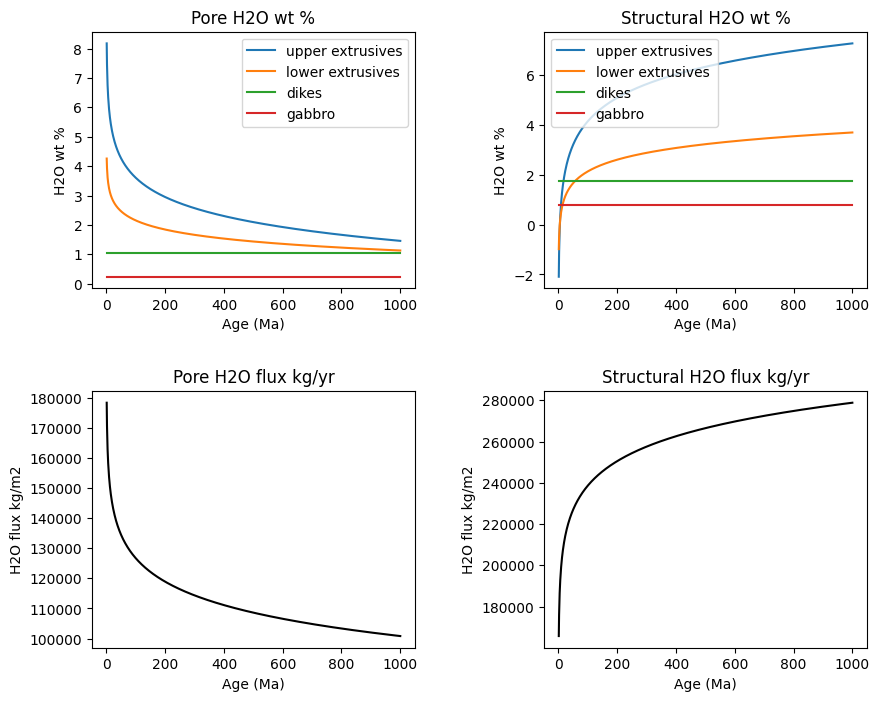

In [21]:
age = np.arange(1,1001)


labels = ['upper extrusives', 'lower extrusives', 'dikes', 'gabbro']

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(221,  ylabel='H2O wt %', title='Pore H2O wt %', xlabel='Age (Ma)')
for i, wt in enumerate(total_crust_H2O_wt_pore(age)):
    ax1.plot(age, wt, label=labels[i])


ax2 = fig.add_subplot(222,  ylabel='H2O wt %', title='Structural H2O wt %', xlabel='Age (Ma)')
for i, wt in enumerate(total_crust_H2O_wt_structural(age)):
    ax2.plot(age, wt, label=labels[i])
    

ax1.legend()
ax2.legend()


ax3 = fig.add_subplot(223, ylabel='H2O flux kg/m2', xlabel='Age (Ma)', title='Pore H2O flux kg/yr')
ax3.plot(age, total_crust_H2O_flux_pore(age), c='k')

ax4 = fig.add_subplot(224, ylabel='H2O flux kg/m2', xlabel='Age (Ma)', title='Structural H2O flux kg/yr')
ax4.plot(age, total_crust_H2O_flux_structural(age), c='k')


fig.subplots_adjust(hspace=0.4, wspace=0.4)

# ax1.plot(age, macro_porosity(age), c='k')

In [22]:
age_grid = gplately.Raster(filename=agegrid_filename.format(0), resample=(spacingX,spacingY))
age_grid.fill_NaNs(inplace=True)
age_interp = age_grid.interpolate(subduction_lon, subduction_lat)

volatile_output = total_crust_H2O_flux_structural(age_interp)

print("-- Structural H2O flux --")
print("Average volatile uptake = {:.2f} kg/m2".format(np.nanmean(volatile_output)))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    np.nansum(volatile_output*subduction_length*subduction_convergence)*1e-9,
    np.nansum(volatile_output*subduction_length*subduction_convergence)/1e12))

volatile_output = total_crust_H2O_flux_pore(age_interp)

print("-- Pore H2O flux --")
print("Average volatile uptake = {:.2f} kg/m2".format(np.nanmean(volatile_output)))
print("Global volatile uptake = {:.2f} Mt/yr = {:.2f} x10^12 kg/yr".format(
    np.nansum(volatile_output*subduction_length*subduction_convergence)*1e-9,
    np.nansum(volatile_output*subduction_length*subduction_convergence)/1e12))

-- Structural H2O flux --
Average volatile uptake = 226342.06 kg/m2
Global volatile uptake = 607.31 Mt/yr = 0.61 x10^12 kg/yr
-- Pore H2O flux --
Average volatile uptake = 135095.45 kg/m2
Global volatile uptake = 361.07 Mt/yr = 0.36 x10^12 kg/yr


/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_96599/141149850.py:2: RuntimeWarning: divide by zero encountered in log10
  return 13.01 - 5.625*np.log10(age)
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_96599/141149850.py:65: RuntimeWarning: divide by zero encountered in log10
  m_rho_u = 3.01 - 0.0631*np.log10(age)
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_96599/141149850.py:66: RuntimeWarning: divide by zero encountered in log10
  m_rho_l = 3.01 - 0.5*0.0631*np.log10(age)
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_96599/141149850.py:8: RuntimeWarning: invalid value encountered in add
  return (0.01*phi)*1.02 + (1.0 - 0.01*phi)*rho
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_96599/141149850.py:14: RuntimeWarning: divide by zero encountered in log10
  rho_u = 3.01 - 0.0631*np.log10(age)
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_96599/141149850.py:15: RuntimeWarning: divide by zero encountered in 

In [23]:
water_crust_bound_filename = crust_bound_dir+"{}/water_crust_grid_{}.nc"
water_crust_pore_filename  = crust_pore_dir +"{}/water_crust_grid_{}.nc"

def reconstruct_water_crust(reconstruction_time):
    # compacted sediment thickness (metres)
    age_grid = read_netcdf_grid(agegrid_filename.format(reconstruction_time), resample=(spacingX,spacingY))

    ## Bound H2O
    water_crust_bound_grid = total_crust_H2O_flux_structural(age_grid) * 1e-9
    water_crust_bound = np.ma.array([water_crust_bound_grid*0.9,water_crust_bound_grid,water_crust_bound_grid*1.1])
    
    ## Pore H2O
    water_crust_pore_grid  = total_crust_H2O_flux_pore(age_grid) * 1e-9
    water_crust_pore  = np.ma.array([water_crust_pore_grid*0.9, water_crust_pore_grid, water_crust_pore_grid*1.1])

    
    total_water_crust_bound = np.nansum(water_crust_bound*cell_area, axis=(1,2))
    total_water_crust_pore  = np.nansum(water_crust_pore*cell_area, axis=(1,2))

    if save_output_netcdf:
        for i, m in enumerate(['min', 'mean', 'max']):
            write_netcdf_grid(water_crust_bound_filename.format(m, reconstruction_time),
                              water_crust_bound[i])
            
            write_netcdf_grid(water_crust_pore_filename.format(m, reconstruction_time),
                              water_crust_pore[i])
    
    return np.array(np.hstack([total_water_crust_bound, total_water_crust_pore]))

In [24]:
total_water_crust = Parallel(n_jobs=-2, verbose=1)(
    delayed(reconstruct_water_crust)(time) for time in reconstruction_times)

total_water_crust = np.array(total_water_crust)
total_water_crust_bound = total_water_crust[:,:3]
total_water_crust_pore  = total_water_crust[:,3:]

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  9.9min finished


## Total water

A plot of all contributions to the global water budget

In [25]:
def smooth_1D(array, sigma=3.0, axis=0):
    """ Gaussian filter with standard deviation """
    return ndimage.gaussian_filter1d(array, sigma, axis=axis)

import scipy.ndimage as sn

# This works for smoothing arrays with a (4,1000,3) shape.
def median_filter_3d(array, time_window):
    smooth_result = np.zeros_like(array)
    for c in range(array.shape[0]):
        for i in range(3):
            smooth_result[c,:,i] = sn.median_filter(array[c,:,i], size=time_window)
            
    return smooth_result

# This works for smoothing arrays with a 2D, i.e. (1000,3) shape.
def median_filter_2d(array, time_window):
    smooth_result = np.zeros_like(array)
    for i in range(array.shape[-1]):
        smooth_result[:,i] = sn.median_filter(array[:,i], size=time_window)
    
    return smooth_result


In [26]:
import pandas as pd

time_window = 10 # myr

data_out = [median_filter_2d(total_water_lithosphere_bottom, time_window),
            median_filter_2d(total_water_lithosphere_top, time_window),
            median_filter_2d(total_water_crust_bound, time_window),
            median_filter_2d(total_water_crust_pore, time_window),
            median_filter_2d(total_water_sediment_bound, time_window),
            median_filter_2d(total_water_sediment_pore, time_window)]

total_water = np.array(data_out).sum(axis=0)
data_out.append(total_water)

headers  = ['lithosphere_bottom', 'lithosphere_top',
            'crust_bound', 'crust_pore',
            'sediment_bound', 'sediment_pore',
            'total']
quantiles = ['min', 'mean', 'max']

index = pd.MultiIndex.from_product([headers, quantiles])
df = pd.DataFrame(np.column_stack(data_out), columns=index, index=reconstruction_times)
df.to_csv(figure_dir+'/01-in-plate-water.csv', index_label='Age (Ma)')


# df = pd.read_csv("figures/01-in-plate-water.csv", header=[0,1], index_col=0)

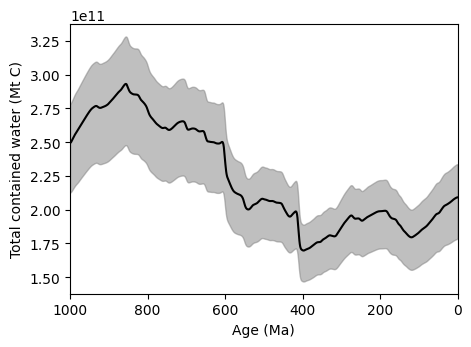

In [27]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Total contained water (Mt C)', xlim=[max_time,min_time])
ax.fill_between(reconstruction_times, smooth_1D(total_water[:,0]), smooth_1D(total_water[:,2]),
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(reconstruction_times, smooth_1D(total_water[:,1]), 'k',   label='Mean')

fig.savefig(figure_dir+"/total_contained_water.pdf", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/total_contained_water.svg", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/total_contained_water.png", bbox_inches='tight', dpi=300)

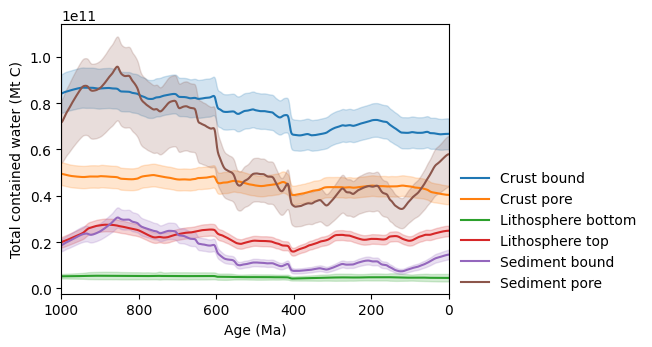

In [28]:
# compare each contribution

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Total contained water (Mt C)', xlim=[max_time,min_time])
# ax.set_yscale('log')

for i, col in enumerate(df.columns.levels[0]):
    if col == 'total':
        continue
    water_contribution = df[col]
    
    ax.fill_between(reconstruction_times,
                    smooth_1D(water_contribution['min']),
                    smooth_1D(water_contribution['max']),
                    color="C{}".format(i), alpha=0.2,)
    
    label = col.replace('_', ' ')
    label = label.capitalize()
    ax.plot(reconstruction_times, smooth_1D(water_contribution['mean']), c='C{}'.format(i), label=label)


ax.legend(bbox_to_anchor=(1,0.5), frameon=False)
fig.savefig(figure_dir+"/total_contained_water_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)

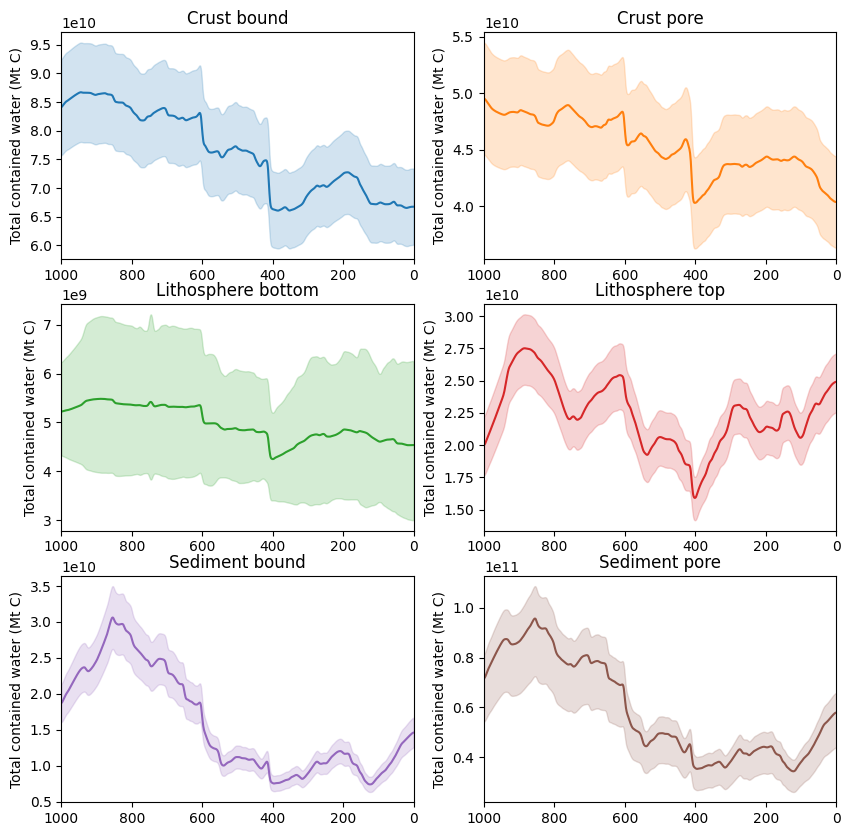

In [29]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10,10))

axes = [ax1,ax2,ax3,ax4,ax5,ax6]


for i, col in enumerate(df.columns.levels[0]):
    if col == 'total':
        continue
    
    ax = axes[i]
#     ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Total contained water (Mt C)')
    ax.set_xlim(max_time,min_time)
    label = col.replace('_', ' ')
    label = label.capitalize()
    ax.set_title(label)
    
    water_contribution = df[col]
    
    ax.fill_between(reconstruction_times,
                    smooth_1D(water_contribution['min']),
                    smooth_1D(water_contribution['max']),
                    color="C{}".format(i), alpha=0.2,)

    ax.plot(reconstruction_times, smooth_1D(water_contribution['mean']), c='C{}'.format(i), label=label)


fig.savefig(figure_dir+"/total_contained_water_comparison.pdf", bbox_inches='tight', dpi=300)